In [1]:
from mpc_full import run

import numpy as np
from matplotlib import pyplot as plt

100.0% solved
Average solve time (ms): 0.089290
(4, 2000)
(2000,)


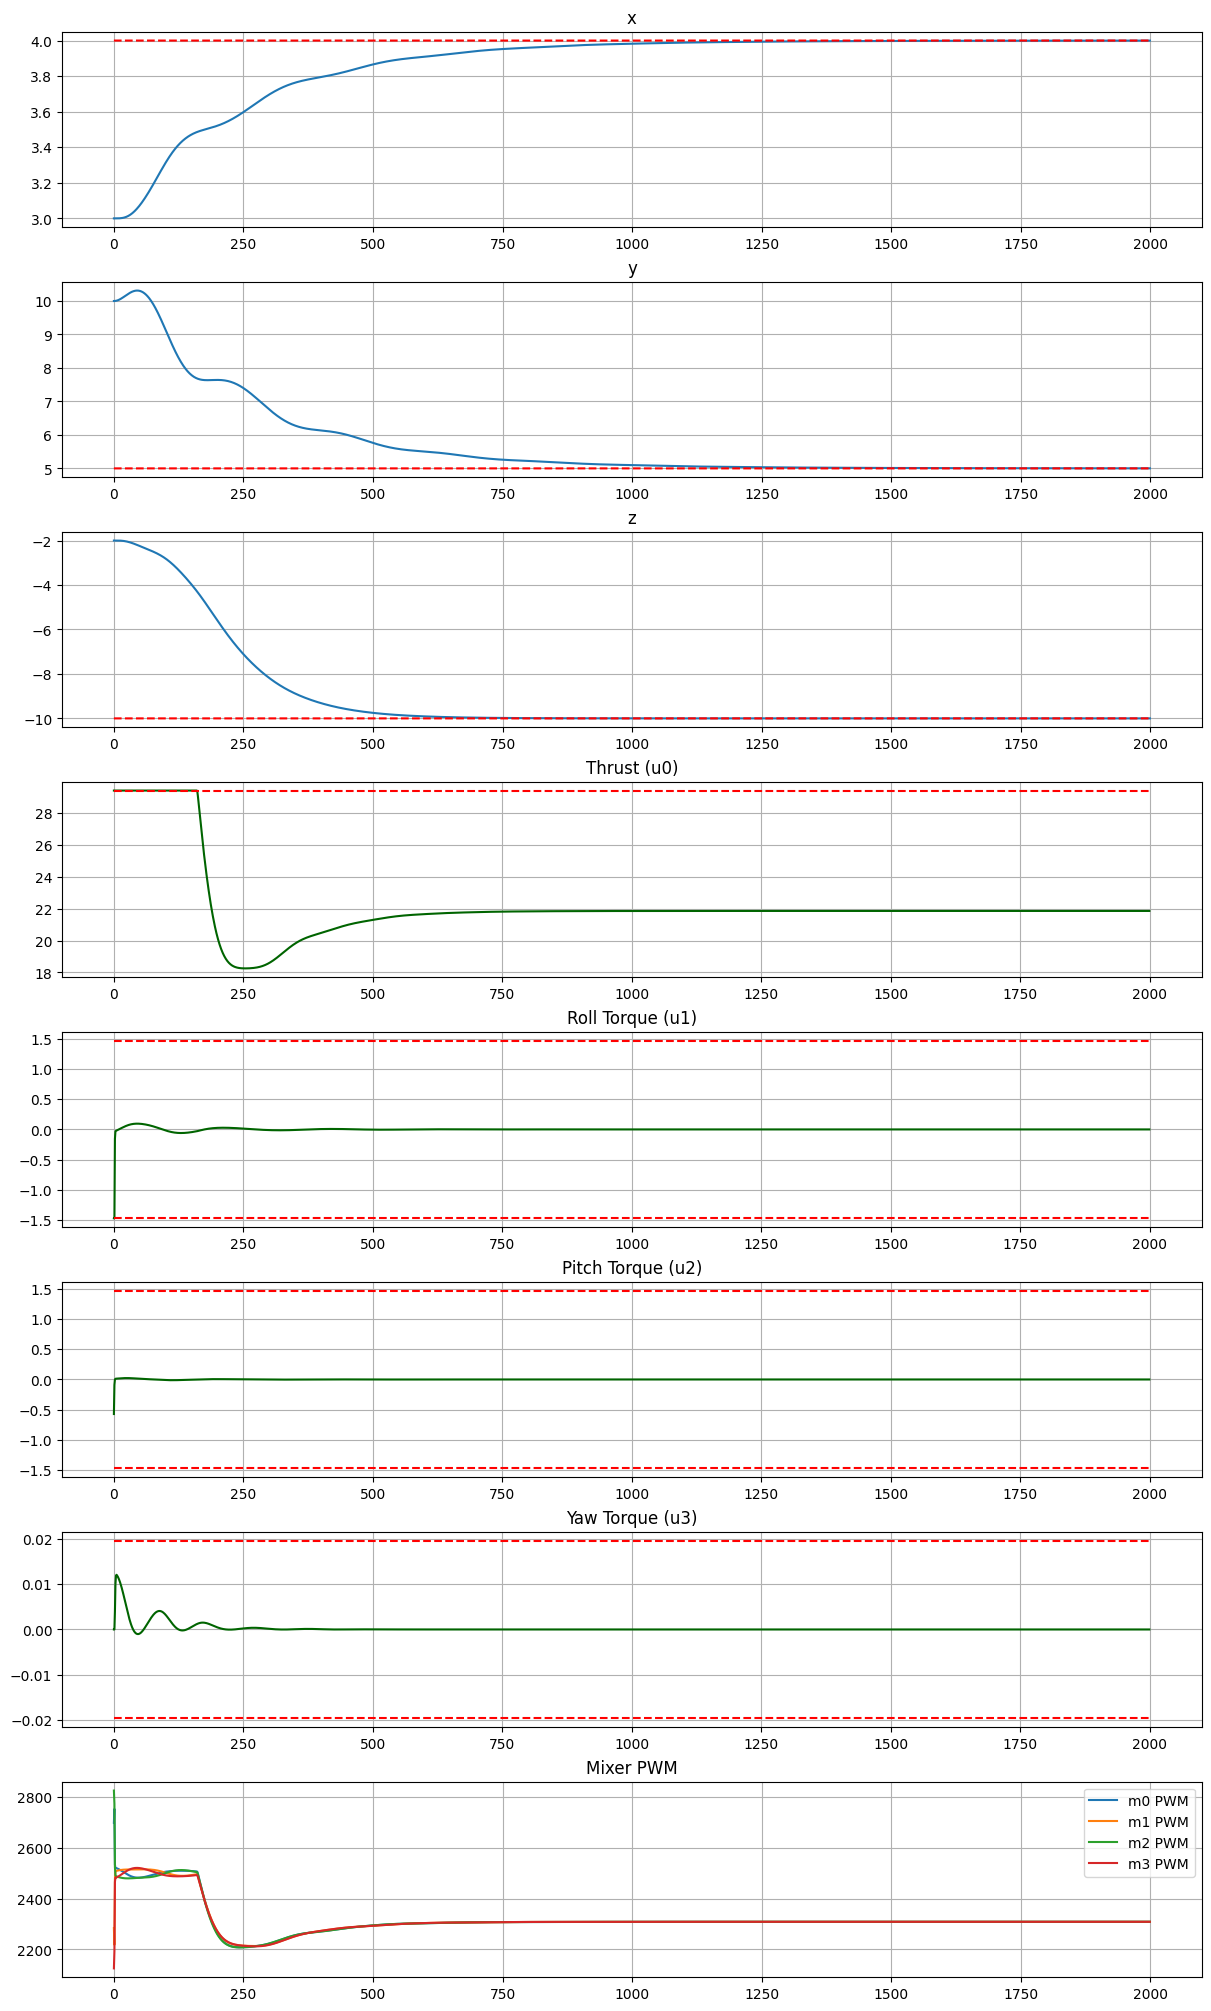

In [17]:
if __name__=="__main__":

    params = {
            ## Geometry and environment variables
            'mass':  2.23, # kg
            'gravity': 9.8, # m/s
            'Ix': 0.008,
            'Iy': 0.015,
            'Iz': 0.017,
            'L': 0.2,

            ## Constraint Variables
            'force_max': 29.4,
            'roll_torque_min': -1.475,
            'roll_torque_max':  1.475,
            'pitch_torque_min': -1.475,
            'pitch_torque_max':  1.475,
            'yaw_torque_min': -0.0196,
            'yaw_torque_max': 0.0196,

            'roll_min': -np.pi/2,
            'roll_max': np.pi/2,
            'pitch_min': -np.pi/2,
            'pitch_max': np.pi/2,

            'xvel_min': -1e6, 
            'xvel_max': 1e6,
            'yvel_min': -1e6,
            'yvel_max': 1e6,
            'zvel_min': -1e6,
            'zvel_max': 1e6,

            'roll_vel_min': -3*np.pi,
            'roll_vel_max': 3*np.pi,
            'pitch_vel_min': -3*np.pi,
            'pitch_vel_max': 3*np.pi,
            'yaw_vel_min': -3*np.pi,
            'yaw_vel_max': 3*np.pi,

            ## Reference
            'constant_ref': np.array([4, 5, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0]),

            ## Initial
            'initial_state': np.array([3, 10, -2, 0.75, 0, 0, 0, 0, 0, 0, 0, 0]),

            ## Penalty
            'state_penalty': np.array([100,100,100, 5,5,5, 10,10,10, 1,1,1]),
            'terminal_multiplier': 10,
            'control_penalty': np.array([0.1,0.1,0.1,0.1]),

            ## Flags
            'reference_limit': False,

            ## Simulation variables
            'step': 0.01,
            'runtime': 20 ## seconds
            }

    output = run(params, generate=True)

    iterations = int(params['runtime']/params['step'])

    ## GRAPH STATE
    x = [output['states'][i][0] for i in range(0,iterations)]
    y = [output['states'][i][1] for i in range(0,iterations)]
    z = [output['states'][i][2] for i in range(0,iterations)]

    fig = plt.figure(figsize=(12, 20), constrained_layout=True)

    ax = fig.add_subplot(8,1,1)
    ax.plot(range(0,len(x)),x, label='x')
    ax.plot(range(0,len(x)), params['constant_ref'][0].repeat(iterations), linestyle='--', color='red')
    ax.set_title('x')
    ax.grid(True)

    ax = fig.add_subplot(8,1,2)
    ax.plot(range(0,len(y)),y)
    ax.plot(range(0,len(y)), params['constant_ref'][1].repeat(iterations), linestyle='--', color='red')
    ax.set_title('y')
    ax.grid(True)

    ax = fig.add_subplot(8,1,3)
    ax.plot(range(0,len(z)),z)
    ax.plot(range(0,len(z)), params['constant_ref'][2].repeat(iterations), linestyle='--', color='red')
    ax.set_title('z')
    ax.grid(True )

    ## GRAPH CONTROL VECTOR
    u0 = [output['controls'][i][0] for i in range(0,iterations)]
    u1 = [output['controls'][i][1] for i in range(0,iterations)]
    u2 = [output['controls'][i][2] for i in range(0,iterations)]
    u3 = [output['controls'][i][3] for i in range(0,iterations)]

    ax = fig.add_subplot(8,1,4)
    ax.plot(range(0,len(u0)),u0, color='darkgreen')
    ax.plot([0,len(u0)],2*[params['force_max']], linestyle='--', color='red')
    ax.set_title('Thrust (u0)')
    ax.grid(True)

    ax = fig.add_subplot(8,1,5)
    ax.plot(range(0,len(u0)),u1, color='darkgreen')
    ax.plot([0,len(u0)],2*[params['roll_torque_max']], linestyle='--', color='red')
    ax.plot([0,len(u0)],2*[params['roll_torque_min']], linestyle='--', color='red')
    ax.set_title('Roll Torque (u1)')
    ax.grid(True)

    ax = fig.add_subplot(8,1,6)
    ax.plot(range(0,len(x)),u2, color='darkgreen')
    ax.set_title('Pitch Torque (u2)')
    ax.plot([0,len(u0)],2*[params['pitch_torque_max']], linestyle='--', color='red')
    ax.plot([0,len(u0)],2*[params['pitch_torque_min']], linestyle='--', color='red')
    ax.grid(True)

    ax = fig.add_subplot(8,1,7)
    ax.plot(range(0,len(x)),u3, color='darkgreen')
    ax.plot([0,len(u0)],2*[params['yaw_torque_max']], linestyle='--', color='red')
    ax.plot([0,len(u0)],2*[params['yaw_torque_min']], linestyle='--', color='red')
    ax.set_title('Yaw Torque (u3)')
    ax.grid(True)

    ### Mixer PWM Outputs
    allocation = np.array([[121951.2195122, -938086.30393996, 609756.09756098, 6097560.97560975],
                           [121951.2195122, 938086.30393996, -609756.09756098, 6097560.97560976],
                           [121951.2195122, -938086.30393996, -609756.09756098, -6097560.97560975],
                           [121951.2195122, 938086.30393996, 609756.09756098, -6097560.97560976]]
                         )
    ctl = np.vstack((np.add(u0,params['mass']*params['gravity']), u1, u2, u3))
    out = allocation@ctl
    out = np.sqrt(out)
    print(out.shape)
    print(out[0,:].shape)

    ax = fig.add_subplot(8,1,8)
    ax.plot(out[0,:], label='m0 PWM')
    ax.plot(out[1,:], label='m1 PWM')
    ax.plot(out[2,:], label='m2 PWM')
    ax.plot(out[3,:], label='m3 PWM')
    ax.set_title('Mixer PWM')
    ax.grid(True)
    ax.legend()

    plt.show()
    